# Credit Risk Analysis

### Projeto 1: Desenvolvimento de um modelo de concessão de crédito.

**Objetivo:** desenvolver um modelo de concessão de crédito (classificação binária) usando as bases `train.gz`, `test.gz` e `oot.gz`.

**Etapas:**
1. Entendimento da base e análise exploratória dos dados;
2. Pré-processamento das variáveis;
3. Treinamento de um modelo de classificação binária;
4. Análise técnica da performance do modelo, medida sobre a base de Teste.

### Base de dados
A base contém 150 variáveis, a maioria das quais está mascarada. Utilize a coluna ID como uma key.

A variável alvo é denominada TARGET e possui os seguintes valores:

- 1: Mau Pagador, i.e. atraso > 60 dias em 2 meses.
- 0: Bom Pagador, i.e. caso contrário.
O score do modelo de classificação deve mapear a classe Bom Pagador.

A base de dados está contida na pasta ../datasets/credit_01 e é dividida em 3 partes:

* Treino: base usada para treinamento contendo dados de janeiro a agosto de 2017;

* Teste: base usada para testes contendo dados de janeiro a agosto de 2017;

* Out-of-time (oot): contém dados obtidos de setembro a novembro de 2017. A escoragem dessa base pode ser uma etapa do desafio, a depender das condições e requisitos combinados.

A base outoftime é considerada uma base "cega" por não possuir a variável "TARGET" (apenas a equipe do Prophet/Neurolake possui acesso a essa variável).

## Import libraries

In [ ]:
# Data cleaning and wrangling
import pandas as pd
import numpy as np

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Validação de modelos
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV,  cross_validate,  StratifiedKFold, train_test_split # a base já vem separada em treino e test como arquivos diferentes

# Pré-processamento 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

# Feature selection
from sklearn.feature_selection import chi2

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Manter saída do processamento do sklearn como DataFrame Pandas
from sklearn import set_config
set_config(transform_output='pandas')


## Import datasets

In [2]:
CREDIT_TRAIN = pd.read_csv('../../datasets/credit_01/train.gz', compression='gzip')
CREDIT_TEST = pd.read_csv('../../datasets/credit_01/test.gz', compression='gzip')
CREDIT_OOT = pd.read_csv('../../datasets/credit_01/oot.gz', compression='gzip')

df_train = CREDIT_TRAIN
df_test = CREDIT_TEST
df_oot = CREDIT_OOT

## Data understanding

In [3]:
df_test.shape

(51751, 151)

In [4]:
df_oot.shape

(91965, 150)

In [5]:
df_train.head(3)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015


Ao que parece:
- REF_DATE - Data
- VAR2 - Sexo
- VAR5 - Estado
- VAR6 - Latitude
- VAR7 - Longitude
- VAR148 - Email

In [6]:
# Exibir informações (pd.options.display.max_info_columns)
df_train.info(verbose=True, memory_usage='deep', show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Data columns (total 151 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    REF_DATE  120750 non-null  object 
 1    TARGET    120750 non-null  int64  
 2    VAR2      106131 non-null  object 
 3    IDADE     107040 non-null  float64
 4    VAR4      202 non-null     object 
 5    VAR5      117394 non-null  object 
 6    VAR6      117394 non-null  float64
 7    VAR7      117394 non-null  float64
 8    VAR8      67640 non-null   object 
 9    VAR9      117447 non-null  object 
 10   VAR10     117474 non-null  object 
 11   VAR11     74488 non-null   float64
 12   VAR12     65724 non-null   float64
 13   VAR13     15530 non-null   float64
 14   VAR14     95197 non-null   float64
 15   VAR15     58269 non-null   float64
 16   VAR16     44981 non-null   float64
 17   VAR17     15530 non-null   float64
 18   VAR18     95197 non-null   float64
 19   VAR19     58269 non-n

In [7]:
# Variáveis com mais nulos
df_train.isna().sum().sort_values(ascending=False).head(25)

VAR146    120582
VAR4      120548
VAR46     120456
VAR45     120456
VAR44     120349
VAR43     120349
VAR145    120071
VAR38     119981
VAR26     119742
VAR27     119708
VAR143    119174
VAR144    119174
VAR31     116833
VAR48     112338
VAR33     112129
VAR34     112129
VAR20     109397
VAR28     108031
VAR30     108031
VAR17     105220
VAR13     105220
VAR23     105220
VAR21     105157
VAR29      96026
VAR37      95706
dtype: int64

In [8]:
# Variáveis com menos nulos
df_train.isna().sum().sort_values(ascending=False).tail(15)
# df_train.notna().sum().sort_values(ascending=False).head(30)



VAR136      2939
VAR132      2939
VAR131      2939
VAR137      2939
VAR138      2939
VAR142       165
VAR39         71
TARGET         0
REF_DATE       0
VAR47          0
VAR141         0
VAR147         0
VAR148         0
VAR149         0
ID             0
dtype: int64

Somente as variáveis TARGET, REF_DATE, VAR47, VAR141, VAR147, VAR148, VAR149 e ID não possuem nulos.

In [9]:
# Variáveis com apenas 1 valor (constante)
df_train.nunique().sort_values(ascending=False).tail(10)

VAR49     2
VAR48     2
VAR4      1
VAR36     1
VAR38     1
VAR33     1
VAR45     1
VAR43     1
VAR35     1
VAR149    1
dtype: int64

As variáveis VAR4, VAR33, VAR35, VAR36, VAR38, VAR43, VAR45, VAR149 possuem apenas 1 valor. 

In [10]:
# Análise descritiva das variáveis contínuas
df_train.describe()

,TARGET,IDADE,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,...,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147,ID
count,120750.000000,107040.000000,117394.000000,117394.000000,74488.000000,65724.000000,15530.000000,95197.000000,58269.000000,44981.000000,...,117811.000000,107048.000000,401.000000,294.000000,120750.000000,120750.000000,679.000000,168.000000,120750.000000,120750.000000
mean,0.245027,42.125255,-14.411389,-45.903480,0.235917,0.290241,0.313850,0.241245,0.185754,2.044374,...,0.631175,0.504619,1691.738429,6984.218469,0.256543,1854.833006,4018.743785,1942.649762,101.841656,165324.864199
std,0.430105,15.198476,8.995077,7.529788,0.625609,0.308937,0.241229,0.262687,0.195320,3.170869,...,0.222607,0.069614,2177.830516,4621.964093,0.406746,893.999792,3700.836248,3143.757850,0.540016,95488.442320
min,0.000000,18.014000,-33.521563,-72.900276,-4.000000,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.006658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,3.000000
25%,0.000000,30.057250,-22.842778,-49.903564,0.000000,0.055000,0.056000,0.105000,0.078000,0.250000,...,0.440572,0.463579,642.000000,3888.995000,0.000000,1513.227400,1633.195000,0.000000,102.000000,82727.250000
50%,0.000000,39.867000,-13.010590,-46.574908,0.000000,0.159000,0.318000,0.140000,0.112000,0.833333,...,0.542298,0.496036,769.000000,5386.310000,0.003000,1627.157652,3024.480000,935.120000,102.000000,165298.000000
75%,0.000000,52.997000,-6.357067,-39.023621,0.000000,0.505000,0.507000,0.168000,0.153000,2.416667,...,0.898052,0.522576,1747.500000,9601.390000,0.421000,1820.670284,5217.670000,2260.125000,102.000000,248248.000000
max,1.000000,105.477000,4.602823,-32.429516,4.000000,1.500000,1.000000,1.700000,1.000000,15.999999,...,1.000000,0.910865,17374.940000,26523.920000,1.000000,33954.140000,33954.140000,17229.200000,102.000000,330581.000000


A VAR11 vai de -4 a 4; e a VAR147 apresenta na sua maioria o valor 102.

As variáveis VAR6, VAR7 e VAR11 possuem valores negativos, porém, ao que parece as VAR6, VAR7 são dados de latitude e longitude e a VAR11 pode indicar uma categorização/score.

In [11]:
# Identificando categorias das colunas

categ_cols = df_train[['VAR11', 'VAR147']]

categ_per_column = {
    col: categ_cols[col].unique()
    for col in categ_cols.columns if categ_cols[col].nunique() >= 1 # filtrando por 3 ou mais categorias
}

# Exibindo as categorias
print("Categorias por coluna:")
for col, categories in categ_per_column.items():
    print(f"{col}: {list(categories)}")

Categorias por coluna:
VAR11: [np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(3.0), np.float64(2.0), np.float64(4.0), np.float64(-1.0), np.float64(-2.0), np.float64(-3.0), np.float64(-4.0)]
VAR147: [np.int64(102), np.int64(100)]


A VAR11 tem 9 valores e a VAR147 tem 2.

<Axes: xlabel='IDADE', ylabel='Count'>

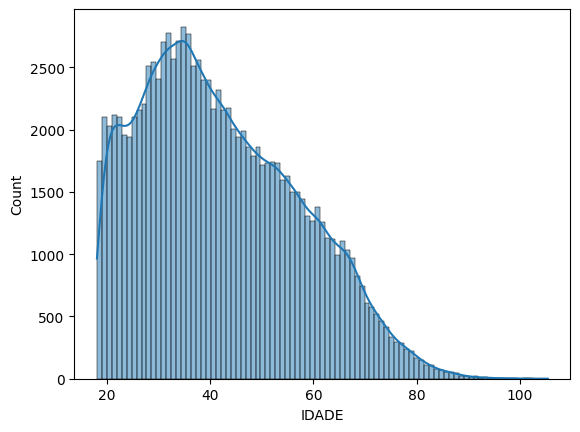

In [12]:
# Distribuição da idade
sns.histplot(df_train, x='IDADE', kde=True)

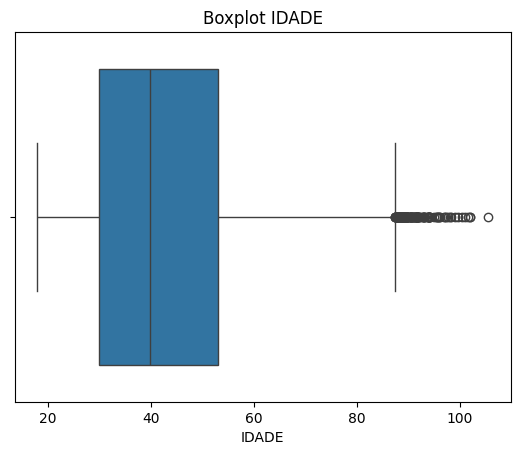

In [13]:
sns.boxplot(data=df_train, x='IDADE')
plt.title("Boxplot IDADE")
plt.show()

Grupo composto por pessoas com:
- Média de Idade: 42.12
- Mediana de Idade: 39.86



In [14]:
# Valores mínimos e máximos da data de referência
print(f"Referência antiga: {df_train['REF_DATE'].min()}")
print(f"Referência recente: {df_train['REF_DATE'].max()}")

Referência antiga: 2017-01-02 00:00:00+00:00
Referência recente: 2017-08-31 00:00:00+00:00


In [15]:
# Quantidade de casos de Target por Estado
df_train.groupby(by=['VAR5'])[['TARGET']].count()

,TARGET
VAR5,
AC,2304
AL,2800
AM,4145
AP,1292
BA,10306
CE,8262
DF,790
ES,2765
GO,2369


In [16]:
# Verificar os valores de TARGET por estado

if "VAR5" in df_train.columns and "TARGET" in df_train.columns:
    # Verificar valores únicos na coluna 'Estado' (opcional, para validação)
    print("Estados disponíveis:", df_train["VAR5"].unique())

    # Agregar os dados
    agregacao = df_train.groupby("VAR5")["TARGET"].value_counts().unstack(fill_value=0) # unstack preenche os estados sem registros específicos com 0

    # Renomear as colunas para clareza
    agregacao.columns = ["TARGET_0", "TARGET_1"]

    # Adicionar uma coluna com o total de observações por estado
    agregacao["Total"] = agregacao["TARGET_0"] + agregacao["TARGET_1"]
    
    # Calcular percentuais
    agregacao["Percentual_TARGET_0"] = (agregacao["TARGET_0"] / agregacao["Total"] * 100).round(2)
    agregacao["Percentual_TARGET_1"] = (agregacao["TARGET_1"] / agregacao["Total"] * 100).round(2)

    # Exibir o DataFrame resultante
    print(agregacao.sort_values(by='Percentual_TARGET_0', ascending=False))
    

Estados disponíveis: ['RO' 'PB' 'RS' 'BA' 'SP' 'MG' 'RJ' 'MS' 'PR' 'SC' 'RN' nan 'CE' 'AC' 'PE'
 'TO' 'AL' 'MT' 'ES' 'MA' 'AM' 'PI' 'DF' 'GO' 'PA' 'SE' 'RR' 'AP']
      TARGET_0  TARGET_1  Total  Percentual_TARGET_0  Percentual_TARGET_1
VAR5                                                                     
SC        1618       395   2013                80.38                19.62
MS        2014       501   2515                80.08                19.92
AC        1844       460   2304                80.03                19.97
MT        1609       406   2015                79.85                20.15
RO        1380       351   1731                79.72                20.28
PR        2907       761   3668                79.25                20.75
MG        6061      1696   7757                78.14                21.86
PI        1447       411   1858                77.88                22.12
RS        6544      1866   8410                77.81                22.19
TO         594       17

Top 3 estados com **mais registros:**
1. SP
2. BA
3. PA
   
Top 3 estados com maior percentual de **melhor pagador:**
1. SC
2. MS
3. AC

Top 3 estados com maior percentual de **pior pagador** (gráfico abaixo):
1. AP
2. AL
3. RR



<Axes: xlabel='VAR5', ylabel='TARGET'>

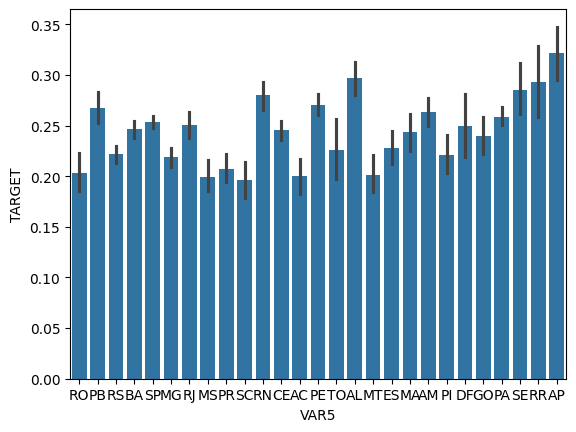

In [17]:
sns.barplot(df_train, x='VAR5', y='TARGET',)

In [18]:
df_train.groupby(by=['VAR2'])[['TARGET']].count()

,TARGET
VAR2,
F,60131
M,46000


In [19]:
# Verificar os valores de TARGET por estado

if "VAR2" in df_train.columns and "TARGET" in df_train.columns:
    # Verificar valores únicos na coluna 'Estado' (opcional, para validação)
    print("Sexo disponíveis:", df_train["VAR2"].unique())

    # Agregar os dados
    agrega = df_train.groupby("VAR2")["TARGET"].value_counts().unstack(fill_value=0) # unstack preenche os estados sem registros específicos com 0

    # Renomear as colunas para clareza
    agrega.columns = ["TARGET_0", "TARGET_1"]

    # Adicionar uma coluna com o total de observações por estado
    agrega["Total"] = agrega["TARGET_0"] + agrega["TARGET_1"]
    
    # Calcular percentuais
    agrega["Percentual_TARGET_0"] = (agrega["TARGET_0"] / agrega["Total"] * 100).round(2)
    agrega["Percentual_TARGET_1"] = (agrega["TARGET_1"] / agrega["Total"] * 100).round(2)

    # Exibir o DataFrame resultante
    print(agrega.sort_values(by='Total', ascending=False))

Sexo disponíveis: ['M' 'F' nan]
      TARGET_0  TARGET_1  Total  Percentual_TARGET_0  Percentual_TARGET_1
VAR2                                                                     
F        47360     12771  60131                78.76                21.24
M        33669     12331  46000                73.19                26.81


A maioria dos clientes são do sexo feminino, que também tem maior percentual de bom pagador.

<Axes: xlabel='VAR2', ylabel='TARGET'>

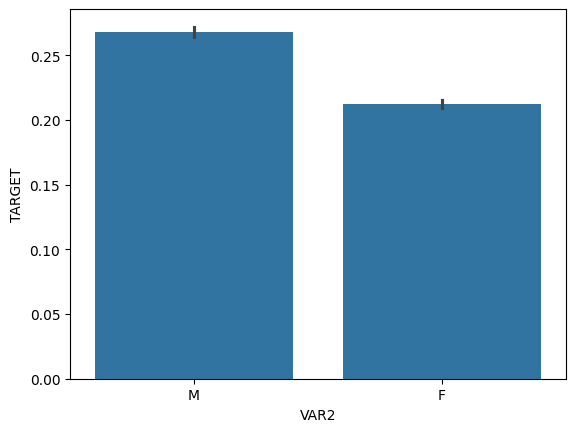

In [20]:
sns.barplot(df_train, x='VAR2', y='TARGET')

<Axes: xlabel='TARGET', ylabel='ID'>

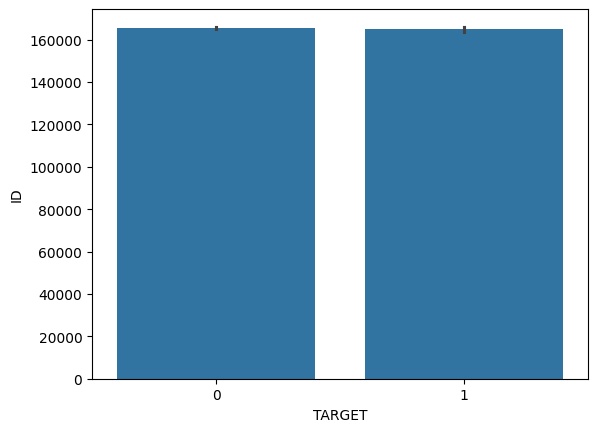

In [21]:
# Quantidade de casos de bom e mau pagador
sns.barplot(df_train, x='TARGET', y='ID')

## Data preparation

In [22]:
# Set ID as index

df = df_train.set_index('ID')
df.head()


,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,MUITO PROXIMO,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1


In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,120750.0,0.245027,0.430105,0.000000,0.000000,0.000000,0.000000,1.000000
IDADE,107040.0,42.125255,15.198476,18.014000,30.057250,39.867000,52.997000,105.477000
VAR6,117394.0,-14.411389,8.995077,-33.521563,-22.842778,-13.010590,-6.357067,4.602823
VAR7,117394.0,-45.903480,7.529788,-72.900276,-49.903564,-46.574908,-39.023621,-32.429516
VAR11,74488.0,0.235917,0.625609,-4.000000,0.000000,0.000000,0.000000,4.000000
VAR12,65724.0,0.290241,0.308937,0.000000,0.055000,0.159000,0.505000,1.500000
VAR13,15530.0,0.313850,0.241229,0.000000,0.056000,0.318000,0.507000,1.000000
VAR14,95197.0,0.241245,0.262687,0.000000,0.105000,0.140000,0.168000,1.700000
VAR15,58269.0,0.185754,0.195320,0.000000,0.078000,0.112000,0.153000,1.000000
VAR16,44981.0,2.044374,3.170869,0.083333,0.250000,0.833333,2.416667,15.999999


In [24]:
# Remoção de dados duplicados
df.drop_duplicates()

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,MUITO PROXIMO,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,2017-03-07 00:00:00+00:00,0,M,30.474,NaN,BA,-12.900183,-38.673056,E,E,...,MUITO LONGE,1752.116912,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
315754,2017-07-27 00:00:00+00:00,0,F,19.570,NaN,SP,-22.172110,-47.374184,E,E,...,LONGE,1510.234174,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1
156370,2017-05-04 00:00:00+00:00,0,M,32.882,NaN,SP,-22.327290,-49.033763,NaN,E,...,LONGE,1736.106081,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1


Após a remoção de linhas duplicadas restaram 120575.

### Date Format 

In [25]:
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])



In [26]:
df.dtypes

REF_DATE    datetime64[ns, UTC]
TARGET                    int64
VAR2                     object
IDADE                   float64
VAR4                     object
                   ...         
VAR145                  float64
VAR146                  float64
VAR147                    int64
VAR148                   object
VAR149                   object
Length: 150, dtype: object

In [26]:
df.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,MUITO PROXIMO,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1


### Missing values

In [27]:
# Calculo do percentual de valores nulos por coluna
perc_nulos = df.isnull().mean() * 100

# Exibição do resultado
print(perc_nulos.sort_values(ascending=False).head(35))

VAR146    99.860870
VAR4      99.832712
VAR46     99.756522
VAR45     99.756522
VAR43     99.667909
VAR44     99.667909
VAR145    99.437681
VAR38     99.363147
VAR26     99.165217
VAR27     99.137060
VAR143    98.694824
VAR144    98.694824
VAR31     96.756108
VAR48     93.033540
VAR33     92.860455
VAR34     92.860455
VAR20     90.597930
VAR30     89.466667
VAR28     89.466667
VAR13     87.138716
VAR23     87.138716
VAR17     87.138716
VAR21     87.086542
VAR29     79.524638
VAR36     79.259627
VAR37     79.259627
VAR35     78.388406
VAR32     65.174327
VAR16     62.748654
VAR25     51.744099
VAR19     51.744099
VAR15     51.744099
VAR22     51.694410
VAR12     45.570186
VAR8      43.983437
dtype: float64


33 variávies possuem mais de 50% de dados nulos

#### Dataset com 50% dos nulos removidos

In [28]:
# Remoção de colunas com mais de 50% de nulos

null_prop = df.isnull().mean()
remove_col = null_prop[null_prop > 0.5].index
df_train_drop_half = df.drop(columns=remove_col)

print(df_train_drop_half.info(verbose=True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 117 columns):
 #    Column    Non-Null Count   Dtype              
---   ------    --------------   -----              
 0    REF_DATE  120750 non-null  datetime64[ns, UTC]
 1    TARGET    120750 non-null  int64              
 2    VAR2      106131 non-null  object             
 3    IDADE     107040 non-null  float64            
 4    VAR5      117394 non-null  object             
 5    VAR6      117394 non-null  float64            
 6    VAR7      117394 non-null  float64            
 7    VAR8      67640 non-null   object             
 8    VAR9      117447 non-null  object             
 9    VAR10     117474 non-null  object             
 10   VAR11     74488 non-null   float64            
 11   VAR12     65724 non-null   float64            
 12   VAR14     95197 non-null   float64            
 13   VAR18     95197 non-null   float64            
 14   VAR24     97285 non-null   float64

Após a remoção de colunas com mais de 50% de valores nulos, restaram 117 colunas.

In [29]:
df_train_drop_half.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,...,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,RO,-8.808779,-63.878470,D,E,BAIXA,...,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,PB,-7.146537,-34.926080,E,E,MEDIA,...,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,RS,-27.900178,-53.314035,NaN,E,ALTISSIMA,...,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,BA,-12.948874,-38.451863,E,E,MEDIA,...,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,RS,-30.051810,-51.213277,B,E,MEDIA,...,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102,EMAIL INEXISTENTE,2.6.1


In [30]:
df_train_drop_half.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 117 columns):
 #    Column    Non-Null Count   Dtype              
---   ------    --------------   -----              
 0    REF_DATE  120750 non-null  datetime64[ns, UTC]
 1    TARGET    120750 non-null  int64              
 2    VAR2      106131 non-null  object             
 3    IDADE     107040 non-null  float64            
 4    VAR5      117394 non-null  object             
 5    VAR6      117394 non-null  float64            
 6    VAR7      117394 non-null  float64            
 7    VAR8      67640 non-null   object             
 8    VAR9      117447 non-null  object             
 9    VAR10     117474 non-null  object             
 10   VAR11     74488 non-null   float64            
 11   VAR12     65724 non-null   float64            
 12   VAR14     95197 non-null   float64            
 13   VAR18     95197 non-null   float64            
 14   VAR24     97285 non-null   float64

In [31]:
df_train_drop_half[['VAR11','VAR93', 'VAR9']].nunique()

VAR11    9
VAR93    3
VAR9     5
dtype: int64

In [32]:
df_train_drop_half.nunique().sort_values(ascending=True).head(50)

VAR149    1
TARGET    2
VAR55     2
VAR2      2
VAR60     2
VAR59     2
VAR58     2
VAR56     2
VAR53     2
VAR54     2
VAR51     2
VAR52     2
VAR49     2
VAR50     2
VAR62     2
VAR57     2
VAR64     2
VAR63     2
VAR90     2
VAR65     2
VAR120    2
VAR147    2
VAR100    2
VAR61     2
VAR67     3
VAR82     3
VAR93     3
VAR95     3
VAR68     4
VAR66     4
VAR70     4
VAR69     4
VAR89     4
VAR85     4
VAR79     4
VAR77     4
VAR80     4
VAR83     4
VAR84     4
VAR78     4
VAR86     4
VAR98     4
VAR74     4
VAR75     4
VAR73     4
VAR72     4
VAR76     4
VAR92     4
VAR97     4
VAR101    4
dtype: int64

In [33]:
# Remoção de variáveis pouco explicativas: latitude, longitude, email e um código com um único valor
df_train_drop_half = df_train_drop_half.drop(columns=['REF_DATE','VAR148', 'VAR149','VAR6', 'VAR7'])

df_train_drop_half

,TARGET,VAR2,IDADE,VAR5,VAR8,VAR9,VAR10,VAR11,VAR12,VAR14,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,0,M,34.137,RO,D,E,BAIXA,1.0,0.182,0.141,...,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102
287633,0,M,40.447,PB,E,E,MEDIA,0.0,NaN,0.136,...,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102
88015,0,F,33.515,RS,NaN,E,ALTISSIMA,NaN,0.095,0.152,...,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102
122576,1,F,25.797,BA,E,E,MEDIA,0.0,0.359,0.014,...,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102
1272,0,F,54.074,RS,B,E,MEDIA,3.0,0.736,0.207,...,PROXIMO,MUITO PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,0,M,30.474,BA,E,E,ALTISSIMA,0.0,0.714,0.777,...,MUITO LONGE,LONGE,MEDIO,LONGE,LONGE,MUITO LONGE,MUITO LONGE,1752.116912,E,102
315754,0,F,19.570,SP,E,E,MEDIA,0.0,NaN,0.119,...,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,1510.234174,E,102
156370,0,M,32.882,SP,NaN,E,MEDIA,NaN,0.659,0.131,...,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,1736.106081,E,102


As variáveis VAR4, VAR33, VAR35, VAR36, VAR38, VAR43, VAR45 foram removidas com a remoção das colunas com mais de 50% de nulos.

In [ ]:
# separação de dados por tipo de coluna
target = ['TARGET']
num_cols = ['IDADE', 'VAR141', 'VAR39','VAR40','VAR41','VAR42','VAR47','VAR24','VAR18','VAR14', 'VAR12']
cat_cols = [col for col in df_train_drop_half.columns if col not in num_cols + [target]]

print("Colunas categóricas:", cat_cols)

Colunas categóricas: ['TARGET', 'VAR2', 'VAR5', 'VAR8', 'VAR9', 'VAR10', 'VAR11', 'VAR49', 'VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 'VAR57', 'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62', 'VAR63', 'VAR64', 'VAR65', 'VAR66', 'VAR67', 'VAR68', 'VAR69', 'VAR70', 'VAR71', 'VAR72', 'VAR73', 'VAR74', 'VAR75', 'VAR76', 'VAR77', 'VAR78', 'VAR79', 'VAR80', 'VAR81', 'VAR82', 'VAR83', 'VAR84', 'VAR85', 'VAR86', 'VAR87', 'VAR88', 'VAR89', 'VAR90', 'VAR91', 'VAR92', 'VAR93', 'VAR94', 'VAR95', 'VAR96', 'VAR97', 'VAR98', 'VAR99', 'VAR100', 'VAR101', 'VAR102', 'VAR103', 'VAR104', 'VAR105', 'VAR106', 'VAR107', 'VAR108', 'VAR109', 'VAR110', 'VAR111', 'VAR112', 'VAR113', 'VAR114', 'VAR115', 'VAR116', 'VAR117', 'VAR118', 'VAR119', 'VAR120', 'VAR121', 'VAR122', 'VAR123', 'VAR124', 'VAR125', 'VAR126', 'VAR127', 'VAR128', 'VAR129', 'VAR130', 'VAR131', 'VAR132', 'VAR133', 'VAR134', 'VAR135', 'VAR136', 'VAR137', 'VAR138', 'VAR139', 'VAR140', 'VAR142', 'VAR147']


In [35]:
# Seleciona apenas as colunas categóricas
colunas_categoricas  = df_train_drop_half.select_dtypes(include='object')

# Filtra as colunas categóricas com número de categorias entre 3 e 5
colunas_filtradas = [
    coluna for coluna in colunas_categoricas 
    if 3 <= df_train_drop_half[coluna].nunique() <= 5
]

# Exibe as colunas filtradas
print("Variáveis categóricas com entre 3 e 5 categorias:")
print(colunas_filtradas)

# DataFrame com apenas as colunas filtradas
df_filtrado = df_train_drop_half[colunas_filtradas]

# Exibe informações do DataFrame filtrado
print(df_filtrado.info())


Variáveis categóricas com entre 3 e 5 categorias:
['VAR8', 'VAR9', 'VAR10', 'VAR66', 'VAR67', 'VAR68', 'VAR69', 'VAR70', 'VAR71', 'VAR72', 'VAR73', 'VAR74', 'VAR75', 'VAR76', 'VAR77', 'VAR78', 'VAR79', 'VAR80', 'VAR81', 'VAR82', 'VAR83', 'VAR84', 'VAR85', 'VAR86', 'VAR87', 'VAR88', 'VAR89', 'VAR91', 'VAR92', 'VAR93', 'VAR94', 'VAR95', 'VAR96', 'VAR97', 'VAR98', 'VAR99', 'VAR101', 'VAR102', 'VAR103', 'VAR104', 'VAR105', 'VAR106', 'VAR107', 'VAR108', 'VAR109', 'VAR110', 'VAR111', 'VAR112', 'VAR113', 'VAR114', 'VAR115', 'VAR116', 'VAR117', 'VAR118', 'VAR119', 'VAR121', 'VAR122', 'VAR123', 'VAR124', 'VAR125', 'VAR126', 'VAR127', 'VAR128', 'VAR129', 'VAR130', 'VAR131', 'VAR132', 'VAR133', 'VAR134', 'VAR135', 'VAR136', 'VAR137', 'VAR138', 'VAR139', 'VAR140', 'VAR142']
<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 76 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   VAR8    67640 non-null   object
 1   

- 21 variáveis com 2 categorias;
- 4 variáveis com 3 categorias;
- 76 variáveis categóricas com 3 a 5 categorias.

In [36]:
# variáveis com 4 categorias
df_train_drop_half[['VAR67', 'VAR82', 'VAR93', 'VAR95']]

,VAR67,VAR82,VAR93,VAR95
ID,,,,
181755,BAIXISSIMA,ALTA,BAIXISSIMA,BAIXISSIMA
287633,ALTISSIMA,ALTA,ALTA,ALTA
88015,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA
122576,ALTA,ALTISSIMA,ALTISSIMA,ALTA
1272,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA
...,...,...,...,...
163230,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA
315754,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA
156370,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA


In [37]:
# Identificando categorias das colunas

categorical_cols = df_train_drop_half[['VAR9','VAR67', 'VAR82', 'VAR93', 'VAR95', 'VAR121', 'VAR142']]

categories_per_column = {
    col: categorical_cols[col].unique()
    for col in categorical_cols.columns if categorical_cols[col].nunique() >= 3 # filtrando por 3 ou mais categorias
}

# Exibindo as categorias
print("Categorias por coluna:")
for col, categories in categories_per_column.items():
    print(f"{col}: {list(categories)}")

Categorias por coluna:
VAR9: ['E', nan, 'D', 'C', 'B', 'A']
VAR67: ['BAIXISSIMA', 'ALTISSIMA', 'ALTA', nan]
VAR82: ['ALTA', 'BAIXISSIMA', 'ALTISSIMA', nan]
VAR93: ['BAIXISSIMA', 'ALTA', 'ALTISSIMA', nan]
VAR95: ['BAIXISSIMA', 'ALTA', 'ALTISSIMA', nan]
VAR121: ['MUITO LONGE', 'MEDIO', 'PROXIMO', 'LONGE', nan]
VAR142: ['D', 'E', 'C', 'A', nan, 'B']


In [38]:
df_train_drop_half.head()

,TARGET,VAR2,IDADE,VAR5,VAR8,VAR9,VAR10,VAR11,VAR12,VAR14,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,0,M,34.137,RO,D,E,BAIXA,1.0,0.182,0.141,...,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102
287633,0,M,40.447,PB,E,E,MEDIA,0.0,NaN,0.136,...,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102
88015,0,F,33.515,RS,NaN,E,ALTISSIMA,NaN,0.095,0.152,...,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102
122576,1,F,25.797,BA,E,E,MEDIA,0.0,0.359,0.014,...,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102
1272,0,F,54.074,RS,B,E,MEDIA,3.0,0.736,0.207,...,PROXIMO,MUITO PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102


In [39]:
# Transformação
#Substituindo os valores em string por números

# Mapeamentos
mapa_sex = {'M': 0, 'F': 1}
mapa_categ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
mapa_nivel = {'BAIXISSIMA': 0, 'BAIXA': 1, 'MEDIA': 2, 'ALTA': 3, 'ALTISSIMA': 4}
mapa_distancia = {'MUITO PROXIMO': 0, 'PROXIMO': 1, 'MEDIO': 2, 'LONGE': 3, 'MUITO LONGE': 4}

# Função para identificar o tipo da variável
def identificar_tipo_e_mapear(df, col, mapas):
    valores_unicos = df[col].dropna().unique()  # Remove nulos e pega valores únicos
    for tipo, mapa in mapas.items():
        if all(valor in mapa for valor in valores_unicos):  # Verifica se todos os valores estão no mapa
            df[col] = df[col].map(mapa)  # Aplica o mapeamento
            # Converte valores mapeados para inteiro, mantendo NaN
            df[col] = df[col].astype('Int64')  # Usa Int64 (pandas) para suportar NaN como nulo
            return tipo  # Retorna o tipo identificado
    return "Desconhecido"

# Dicionário de mapeamentos para verificação
mapas = {
    'sex': mapa_sex,
    'categ': mapa_categ,
    'nivel': mapa_nivel,
    'distancia': mapa_distancia
}

# Aplicar o mapeamento em todas as colunas com prefixo 'VAR'
tipos_colunas = {}
for col in df_train_drop_half.columns:
    if col.startswith('VAR'):
        tipo = identificar_tipo_e_mapear(df_train_drop_half, col, mapas)
        tipos_colunas[col] = tipo

# Resultado
print("Tipos de colunas identificados:")
print(tipos_colunas)
print("\nDataFrame transformado:")
print(df_train_drop_half)

Tipos de colunas identificados:
{'VAR2': 'sex', 'VAR5': 'Desconhecido', 'VAR8': 'Desconhecido', 'VAR9': 'Desconhecido', 'VAR10': 'Desconhecido', 'VAR11': 'Desconhecido', 'VAR12': 'Desconhecido', 'VAR14': 'Desconhecido', 'VAR18': 'Desconhecido', 'VAR24': 'Desconhecido', 'VAR39': 'Desconhecido', 'VAR40': 'Desconhecido', 'VAR41': 'Desconhecido', 'VAR42': 'Desconhecido', 'VAR47': 'Desconhecido', 'VAR49': 'Desconhecido', 'VAR50': 'Desconhecido', 'VAR51': 'Desconhecido', 'VAR52': 'Desconhecido', 'VAR53': 'Desconhecido', 'VAR54': 'Desconhecido', 'VAR55': 'Desconhecido', 'VAR56': 'Desconhecido', 'VAR57': 'Desconhecido', 'VAR58': 'Desconhecido', 'VAR59': 'Desconhecido', 'VAR60': 'Desconhecido', 'VAR61': 'Desconhecido', 'VAR62': 'Desconhecido', 'VAR63': 'Desconhecido', 'VAR64': 'Desconhecido', 'VAR65': 'Desconhecido', 'VAR66': 'Desconhecido', 'VAR67': 'Desconhecido', 'VAR68': 'Desconhecido', 'VAR69': 'Desconhecido', 'VAR70': 'Desconhecido', 'VAR71': 'Desconhecido', 'VAR72': 'Desconhecido', 'VAR7

In [40]:
# Transformar estados com one-hot-enconding

"""
encoder = LabelEncoder()
df_train_clean['VAR5'] = encoder.fit_transform(df_train_clean['VAR5'])
df_train_clean
"""

# Inicializa o OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output=True se quiser economizar memória

# Aplica o OneHotEncoder
encoded = encoder.fit_transform(df_train_drop_half[['VAR5']])

# Converte o resultado para um DataFrame para melhor visualização
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['VAR5']))

# Concatena as colunas codificadas ao dataframe original
df_train_drop_half = pd.concat([df_train_drop_half, encoded_df], axis=1).drop(columns='VAR5')

# Exibe o dataframe final
print(df_train_drop_half)

        TARGET  VAR2   IDADE  VAR8  VAR9  VAR10  VAR11  VAR12  VAR14  \
ID                                                                     
181755       0     0  34.137     3     4      1    1.0  0.182  0.141   
287633       0     0  40.447     4     4      2    0.0    NaN  0.136   
88015        0     1  33.515  <NA>     4      4    NaN  0.095  0.152   
122576       1     1  25.797     4     4      2    0.0  0.359  0.014   
1272         0     1  54.074     1     4      2    3.0  0.736  0.207   
...        ...   ...     ...   ...   ...    ...    ...    ...    ...   
163230       0     0  30.474     4     4      4    0.0  0.714  0.777   
315754       0     1  19.570     4     4      2    0.0    NaN  0.119   
156370       0     0  32.882  <NA>     4      2    NaN  0.659  0.131   
232713       1  <NA>     NaN  <NA>     4      2    0.0    NaN    NaN   
187156       0     0  19.342  <NA>     4      2    0.0  0.032    NaN   

           VAR18  ...  VAR5_RJ  VAR5_RN  VAR5_RO  VAR5_RR  VAR5

In [ ]:
cat_cols = []
num_cols = []
target = ['TARGET']

#### Dataset com 10% dos nulos removidos

In [38]:
# Calculo do percentual de valores nulos por coluna
perc_nulos = df.isnull().mean() * 100

# Exibição do resultado
print(perc_nulos.sort_values(ascending=False).head(50))

VAR146    99.860870
VAR4      99.832712
VAR46     99.756522
VAR45     99.756522
VAR43     99.667909
VAR44     99.667909
VAR145    99.437681
VAR38     99.363147
VAR26     99.165217
VAR27     99.137060
VAR143    98.694824
VAR144    98.694824
VAR31     96.756108
VAR48     93.033540
VAR33     92.860455
VAR34     92.860455
VAR20     90.597930
VAR30     89.466667
VAR28     89.466667
VAR13     87.138716
VAR23     87.138716
VAR17     87.138716
VAR21     87.086542
VAR29     79.524638
VAR36     79.259627
VAR37     79.259627
VAR35     78.388406
VAR32     65.174327
VAR16     62.748654
VAR25     51.744099
VAR19     51.744099
VAR15     51.744099
VAR22     51.694410
VAR12     45.570186
VAR8      43.983437
VAR11     38.312215
VAR14     21.161905
VAR18     21.161905
VAR24     19.432712
VAR2      12.106832
IDADE     11.354037
VAR64     11.350725
VAR60     11.350725
VAR59     11.350725
VAR61     11.350725
VAR65     11.350725
VAR62     11.350725
VAR63     11.350725
VAR53     11.350725
VAR58     11.350725


VARIÁVEL | % DE NULOS
---|---
VAR22   |  51.694410
VAR12   | 45.570186
VAR8    |  43.983437
VAR11   |  38.312215
VAR14   |  21.161905
VAR18   | 21.161905
VAR24   |  19.432712
VAR2    |  12.106832
**IDADE**   |  **11.354037**
VAR64   |  11.350725
VAR60   |  11.350725
VAR59   |  11.350725
VAR61   |  11.350725
VAR65   |  11.350725
VAR62   |  11.350725
VAR63   |  11.350725
VAR53   |  11.350725
VAR58   |  11.350725

A variável idade é incluída no corte de 10% de nulos. Mas é algo a se pesar, pois idade pode ser um fator relevante para modelos de classificação.

In [39]:
# Filtrando os nulos do campo idade

# Calculo do percentual de valores nulos por coluna
perc_nulos = df[['IDADE', 'VAR2']].isnull().mean() * 100

# Exibição do resultado
print(perc_nulos)

IDADE    11.354037
VAR2     12.106832
dtype: float64


In [40]:
# Remoção de colunas com mais de 10% de nulos

null_prop = df.isnull().mean()
remove_col = null_prop[null_prop > 0.1].index
df_train_drop_ten = df.drop(columns=remove_col)

print(df_train_drop_ten.info(verbose=True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 91 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  120750 non-null  datetime64[ns, UTC]
 1   TARGET    120750 non-null  int64              
 2   VAR5      117394 non-null  object             
 3   VAR6      117394 non-null  float64            
 4   VAR7      117394 non-null  float64            
 5   VAR9      117447 non-null  object             
 6   VAR10     117474 non-null  object             
 7   VAR39     120679 non-null  float64            
 8   VAR40     117466 non-null  float64            
 9   VAR41     117811 non-null  float64            
 10  VAR47     120750 non-null  float64            
 11  VAR66     117811 non-null  object             
 12  VAR67     117811 non-null  object             
 13  VAR68     117811 non-null  object             
 14  VAR69     117811 non-null  object             
 15  

Após a remoção de colunas com 10% de nulos restaram 91 colunas. Atingiu a coluna de IDADE.

In [41]:
df_train_drop_ten.head()

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,RO,-8.808779,-63.878470,E,BAIXA,0.512334,0.486768,0.357526,...,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,PB,-7.146537,-34.926080,E,MEDIA,0.328021,0.447454,0.414335,...,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,RS,-27.900178,-53.314035,E,ALTISSIMA,0.627262,0.730539,0.916771,...,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,BA,-12.948874,-38.451863,E,MEDIA,0.338643,0.405233,0.408007,...,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,RS,-30.051810,-51.213277,E,MEDIA,0.626047,0.770664,0.907036,...,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102,EMAIL INEXISTENTE,2.6.1


In [42]:
df_train_drop_ten.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,120750.0,0.245027,0.430105,0.000000,0.000000,0.000000,0.000000,1.000000
VAR6,117394.0,-14.411389,8.995077,-33.521563,-22.842778,-13.010590,-6.357067,4.602823
VAR7,117394.0,-45.903480,7.529788,-72.900276,-49.903564,-46.574908,-39.023621,-32.429516
VAR39,120679.0,0.461353,0.144093,0.049309,0.363787,0.462267,0.558495,0.953539
VAR40,117466.0,0.531287,0.115968,0.208688,0.447559,0.510023,0.582701,0.920685
VAR41,117811.0,0.631175,0.222607,0.000000,0.440572,0.542298,0.898052,1.000000
VAR47,120750.0,0.256543,0.406746,0.000000,0.000000,0.003000,0.421000,1.000000
VAR141,120750.0,1854.833006,893.999792,0.000000,1513.227400,1627.157652,1820.670284,33954.140000
VAR147,120750.0,101.841656,0.540016,100.000000,102.000000,102.000000,102.000000,102.000000


In [43]:
df_train_drop_ten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 91 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  120750 non-null  datetime64[ns, UTC]
 1   TARGET    120750 non-null  int64              
 2   VAR5      117394 non-null  object             
 3   VAR6      117394 non-null  float64            
 4   VAR7      117394 non-null  float64            
 5   VAR9      117447 non-null  object             
 6   VAR10     117474 non-null  object             
 7   VAR39     120679 non-null  float64            
 8   VAR40     117466 non-null  float64            
 9   VAR41     117811 non-null  float64            
 10  VAR47     120750 non-null  float64            
 11  VAR66     117811 non-null  object             
 12  VAR67     117811 non-null  object             
 13  VAR68     117811 non-null  object             
 14  VAR69     117811 non-null  object             
 15  

In [44]:
df_train_drop_ten = df_train_drop_ten.drop_duplicates()

In [45]:
df_train_drop_ten.shape

(120449, 91)

##### Outliers

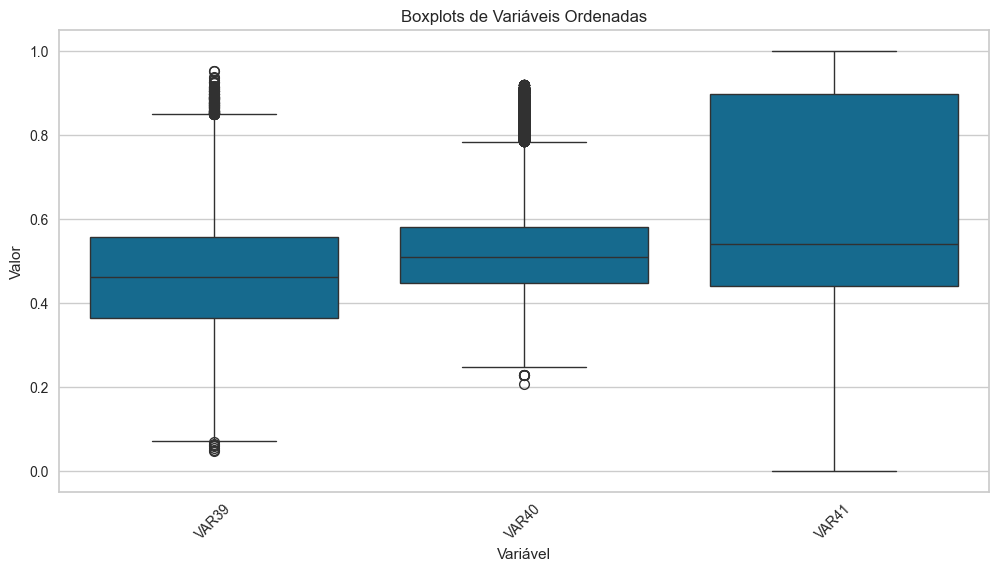

In [47]:
# Boxplot das Variáveis 39, 40 e 41

# Selecionando as variáveis desejadas na ordem correta do dataset df_train_drop_ten
variaveis_desejadas = ["VAR39", "VAR40", "VAR41"]
df_selecionado = df_train_drop_ten[variaveis_desejadas]

# Convertendo para o formato longo
df_long = df_selecionado.melt(var_name="Variável", value_name="Valor")

# Criando o gráfico de boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variável", y="Valor", data=df_long, order=variaveis_desejadas)
plt.title("Boxplots de Variáveis Ordenadas")
plt.xticks(rotation=45)
plt.show()

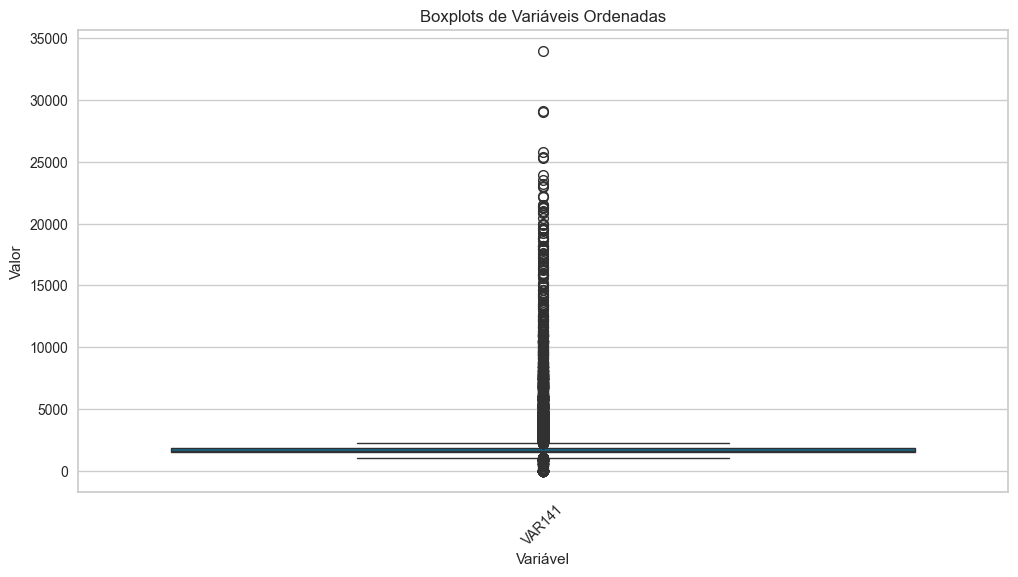

In [48]:
# Boxplot da Variável 141

# Selecionando as variáveis desejadas na ordem correta do dataset df_train_drop_ten
variaveis_desejadas = ["VAR141"]
df_selecionado = df_train_drop_ten[variaveis_desejadas]

# Convertendo para o formato longo
df_long = df_selecionado.melt(var_name="Variável", value_name="Valor")

# Criando o gráfico de boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variável", y="Valor", data=df_long, order=variaveis_desejadas)
plt.title("Boxplots de Variáveis Ordenadas")
plt.xticks(rotation=45)
plt.show()

##### Descarte de variáveis 

In [49]:
df_train_drop_ten.head(3)

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,RO,-8.808779,-63.878470,E,BAIXA,0.512334,0.486768,0.357526,...,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,PB,-7.146537,-34.926080,E,MEDIA,0.328021,0.447454,0.414335,...,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,RS,-27.900178,-53.314035,E,ALTISSIMA,0.627262,0.730539,0.916771,...,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1


In [50]:
df_train_drop_ten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120449 entries, 181755 to 187156
Data columns (total 91 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  120449 non-null  datetime64[ns, UTC]
 1   TARGET    120449 non-null  int64              
 2   VAR5      117286 non-null  object             
 3   VAR6      117286 non-null  float64            
 4   VAR7      117286 non-null  float64            
 5   VAR9      117339 non-null  object             
 6   VAR10     117366 non-null  object             
 7   VAR39     120379 non-null  float64            
 8   VAR40     117358 non-null  float64            
 9   VAR41     117703 non-null  float64            
 10  VAR47     120449 non-null  float64            
 11  VAR66     117703 non-null  object             
 12  VAR67     117703 non-null  object             
 13  VAR68     117703 non-null  object             
 14  VAR69     117703 non-null  object             
 15  

In [51]:
df_train_drop_ten.groupby(by='VAR147').count()

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR148,VAR149
VAR147,,,,,,,,,,,,,,,,,,,,,
100,9553,9553,9533,9533,9533,9535,9537,9553,9535,9550,...,9550,9550,9550,9550,9550,9550,9553,9524,9553,9553
102,110896,110896,107753,107753,107753,107804,107829,110826,107823,108153,...,108153,108153,108153,108153,108153,108153,110896,110760,110896,110896


In [52]:
# Descartando variáveis desnecessárias: VAR148 - email e VAR149 é constante 
drop = ['VAR148', 'VAR149']

df_train_clean = df_train_drop_ten.drop(labels=drop, axis=1)
df_train_clean

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,RO,-8.808779,-63.878470,E,BAIXA,0.512334,0.486768,0.357526,...,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102
287633,2017-08-18 00:00:00+00:00,0,PB,-7.146537,-34.926080,E,MEDIA,0.328021,0.447454,0.414335,...,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102
88015,2017-06-30 00:00:00+00:00,0,RS,-27.900178,-53.314035,E,ALTISSIMA,0.627262,0.730539,0.916771,...,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102
122576,2017-08-05 00:00:00+00:00,1,BA,-12.948874,-38.451863,E,MEDIA,0.338643,0.405233,0.408007,...,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102
1272,2017-07-29 00:00:00+00:00,0,RS,-30.051810,-51.213277,E,MEDIA,0.626047,0.770664,0.907036,...,PROXIMO,MUITO PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,2017-03-07 00:00:00+00:00,0,BA,-12.900183,-38.673056,E,ALTISSIMA,0.292768,0.509101,0.771178,...,MUITO LONGE,LONGE,MEDIO,LONGE,LONGE,MUITO LONGE,MUITO LONGE,1752.116912,E,102
315754,2017-07-27 00:00:00+00:00,0,SP,-22.172110,-47.374184,E,MEDIA,0.626240,0.423891,0.433104,...,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,1510.234174,E,102
156370,2017-05-04 00:00:00+00:00,0,SP,-22.327290,-49.033763,E,MEDIA,0.337504,0.484162,0.467808,...,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,1736.106081,E,102


In [53]:
# Seleciona apenas as colunas categóricas
col_categoricas  = df_train_clean.select_dtypes(include='object')

# Filtra as colunas categóricas com número de categorias entre 3 e 5
col_filtradas = [
    coluna for coluna in col_categoricas 
    if 2 <= df_train_clean[coluna].nunique() <= 6
]

# Exibe as colunas filtradas
print("Variáveis categóricas com entre 3 e 5 categorias:")
print(col_filtradas)

# DataFrame com apenas as colunas filtradas
df_filtro = df_train_clean[col_filtradas]

# Exibe informações do DataFrame filtrado
print(df_filtro.info())

Variáveis categóricas com entre 3 e 5 categorias:
['VAR9', 'VAR10', 'VAR66', 'VAR67', 'VAR68', 'VAR69', 'VAR70', 'VAR71', 'VAR72', 'VAR73', 'VAR74', 'VAR75', 'VAR76', 'VAR77', 'VAR78', 'VAR79', 'VAR80', 'VAR81', 'VAR82', 'VAR83', 'VAR84', 'VAR85', 'VAR86', 'VAR87', 'VAR88', 'VAR89', 'VAR90', 'VAR91', 'VAR92', 'VAR93', 'VAR94', 'VAR95', 'VAR96', 'VAR97', 'VAR98', 'VAR99', 'VAR100', 'VAR101', 'VAR102', 'VAR103', 'VAR104', 'VAR105', 'VAR106', 'VAR107', 'VAR108', 'VAR109', 'VAR110', 'VAR111', 'VAR112', 'VAR113', 'VAR114', 'VAR115', 'VAR116', 'VAR117', 'VAR118', 'VAR119', 'VAR120', 'VAR121', 'VAR122', 'VAR123', 'VAR124', 'VAR125', 'VAR126', 'VAR127', 'VAR128', 'VAR129', 'VAR130', 'VAR131', 'VAR132', 'VAR133', 'VAR134', 'VAR135', 'VAR136', 'VAR137', 'VAR138', 'VAR139', 'VAR140', 'VAR142']
<class 'pandas.core.frame.DataFrame'>
Index: 120449 entries, 181755 to 187156
Data columns (total 78 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   VAR9    117339 n

In [54]:
# Filtrando as colunas que contêm as letras desejadas
letras = ['A', 'B', 'C', 'D', 'E']
colum_filt = df_filtro.columns[df_filtro.isin(letras).any(axis=0)]
df_filtrado = df_filtro[colum_filt]
df_filtrado


,VAR9,VAR142
ID,,
181755,E,D
287633,E,E
88015,E,E
122576,E,E
1272,E,C
...,...,...
163230,E,E
315754,E,E
156370,E,E


Somente a VAR9 e VAR142 são classificadas com letras de A a E

In [55]:
# Identificando categorias das colunas

categor_cols = df_train_clean[['VAR9', 'VAR142', 'VAR80', 'VAR82', 'VAR99']]

categor_per_column = {
    col: categor_cols[col].unique()
    for col in categor_cols.columns if categor_cols[col].nunique() >= 3 # filtrando por 3 ou mais categorias
}

# Exibindo as categorias
print("Categorias por coluna:")
for col, categories in categor_per_column.items():
    print(f"{col}: {list(categories)}")

Categorias por coluna:
VAR9: ['E', nan, 'D', 'C', 'B', 'A']
VAR142: ['D', 'E', 'C', 'A', nan, 'B']
VAR80: ['ALTA', 'BAIXISSIMA', 'ALTISSIMA', 'MEDIA', nan]
VAR82: ['ALTA', 'BAIXISSIMA', 'ALTISSIMA', nan]
VAR99: ['ALTA', 'ALTISSIMA', 'BAIXISSIMA', 'MEDIA', nan, 'BAIXA']


In [56]:
# Filtrando as colunas que contêm as letras desejadas
categ_name = ['ALTA']
colum_filter = df_filtro.columns[df_filtro.isin(categ_name).any(axis=0)]
df_filtered = df_filtro[colum_filter]
df_filtered

,VAR10,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,...,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR101
ID,,,,,,,,,,,,,,,,,,,,,
181755,BAIXA,MEDIA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,ALTISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,...,ALTISSIMA,MEDIA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,MEDIA,ALTA,ALTA
287633,MEDIA,ALTA,ALTISSIMA,ALTA,BAIXISSIMA,ALTA,ALTISSIMA,ALTA,MEDIA,ALTA,...,ALTISSIMA,MEDIA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,MEDIA
88015,ALTISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,...,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA
122576,MEDIA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,...,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA
1272,MEDIA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,...,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,ALTISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,...,BAIXISSIMA,ALTA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA
315754,MEDIA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,ALTA,ALTA,MEDIA,MEDIA,...,MEDIA,MEDIA,BAIXISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,MEDIA,ALTA,MEDIA
156370,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSIMA,...,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTISSIMA


In [57]:
# Contando as ocorrências de cada categoria por coluna removendo as colunas com letras
cl = ['VAR9', 'VAR142']
contagem = df_filtro.drop(cl, axis=1).apply(lambda col: col.value_counts())

# Exibindo o resultado
print(contagem)


                 VAR10    VAR66    VAR67    VAR68    VAR69    VAR70    VAR71  \
ALTA           20825.0  27279.0  16968.0  29575.0  29534.0  27893.0  29905.0   
ALTISSIMA      37221.0  23275.0  25882.0  18957.0  14410.0  21640.0  26810.0   
BAIXA          13567.0      NaN      NaN      NaN      NaN      NaN   5866.0   
BAIXISSIMA      5534.0  32337.0  74853.0  47786.0  65128.0  29344.0  23961.0   
LONGE              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
MEDIA          40219.0  34812.0      NaN  21385.0   8631.0  38826.0  31161.0   
MEDIO              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
MUITO LONGE        NaN      NaN      NaN      NaN      NaN      NaN      NaN   
MUITO PROXIMO      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
PROXIMO            NaN      NaN      NaN      NaN      NaN      NaN      NaN   

                 VAR72    VAR73    VAR74  ...   VAR131   VAR132   VAR133  \
ALTA           30466.0  30367.0  26402.0  .

Obserando as 76 colunas percebo que algumas variáveis estão distribuídas em: ALTISSIMA, ALTA, MEDIA, BAIXA E BAIXISSIMA;
Outras variáveis categóricas estão distribuídas em: MUITO LONGE, LONGE, MEDIO, PROXIMO, e MUITO PROXIMO.

Desse modo, acho interessante substituir esses valores por números assumindo:
- A / BAIXISSIMA / MUITO PROXIMO -> 0
- B / BAIXA / PROXIMO -> 1
- C / MEDIA / MEDIO -> 2
- D / ALTA / LONGE -> 3
- E / ALTISSIMA / MUITO LONGE -> 4

##### Transformação e Imputação de variáveis

In [58]:
#Substituindo os valores em string por números

# Mapeamentos
mapa_categ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
mapa_nivel = {'BAIXISSIMA': 0, 'BAIXA': 1, 'MEDIA': 2, 'ALTA': 3, 'ALTISSIMA': 4}
mapa_distancia = {'MUITO PROXIMO': 0, 'PROXIMO': 1, 'MEDIO': 2, 'LONGE': 3, 'MUITO LONGE': 4}

# Função para identificar o tipo da variável
def identificar_tipo_e_mapear(df, col, mapas):
    valores_unicos = df[col].dropna().unique()  # Remove nulos e pega valores únicos
    for tipo, mapa in mapas.items():
        if all(valor in mapa for valor in valores_unicos):  # Verifica se todos os valores estão no mapa
            df[col] = df[col].map(mapa)  # Aplica o mapeamento
            # Converte valores mapeados para inteiro, mantendo NaN
            df[col] = df[col].astype('Int64')  # Usa Int64 (pandas) para suportar NaN como nulo
            return tipo  # Retorna o tipo identificado
    return "Desconhecido"

# Dicionário de mapeamentos para verificação
mapas = {
    'categ': mapa_categ,
    'nivel': mapa_nivel,
    'distancia': mapa_distancia
}

# Aplicar o mapeamento em todas as colunas com prefixo 'VAR'
tipos_colunas = {}
for col in df_train_clean.columns:
    if col.startswith('VAR'):
        tipo = identificar_tipo_e_mapear(df_train_clean, col, mapas)
        tipos_colunas[col] = tipo

# Resultado
print("Tipos de colunas identificados:")
print(tipos_colunas)
print("\nDataFrame transformado:")
print(df_train_clean)

Tipos de colunas identificados:
{'VAR5': 'Desconhecido', 'VAR6': 'Desconhecido', 'VAR7': 'Desconhecido', 'VAR9': 'categ', 'VAR10': 'nivel', 'VAR39': 'Desconhecido', 'VAR40': 'Desconhecido', 'VAR41': 'Desconhecido', 'VAR47': 'Desconhecido', 'VAR66': 'nivel', 'VAR67': 'nivel', 'VAR68': 'nivel', 'VAR69': 'nivel', 'VAR70': 'nivel', 'VAR71': 'nivel', 'VAR72': 'nivel', 'VAR73': 'nivel', 'VAR74': 'nivel', 'VAR75': 'nivel', 'VAR76': 'nivel', 'VAR77': 'nivel', 'VAR78': 'nivel', 'VAR79': 'nivel', 'VAR80': 'nivel', 'VAR81': 'nivel', 'VAR82': 'nivel', 'VAR83': 'nivel', 'VAR84': 'nivel', 'VAR85': 'nivel', 'VAR86': 'nivel', 'VAR87': 'nivel', 'VAR88': 'nivel', 'VAR89': 'nivel', 'VAR90': 'nivel', 'VAR91': 'nivel', 'VAR92': 'nivel', 'VAR93': 'nivel', 'VAR94': 'nivel', 'VAR95': 'nivel', 'VAR96': 'nivel', 'VAR97': 'nivel', 'VAR98': 'nivel', 'VAR99': 'nivel', 'VAR100': 'nivel', 'VAR101': 'nivel', 'VAR102': 'distancia', 'VAR103': 'distancia', 'VAR104': 'distancia', 'VAR105': 'distancia', 'VAR106': 'distanc

In [59]:
df_train_clean.head(3)

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,RO,-8.808779,-63.878470,4,1,0.512334,0.486768,0.357526,...,3,2,4,3,3,2,3,2680.289259,3,102
287633,2017-08-18 00:00:00+00:00,0,PB,-7.146537,-34.926080,4,2,0.328021,0.447454,0.414335,...,2,1,1,3,3,3,4,1777.725469,4,102
88015,2017-06-30 00:00:00+00:00,0,RS,-27.900178,-53.314035,4,4,0.627262,0.730539,0.916771,...,3,4,3,3,4,3,0,1695.494979,4,102


In [60]:
df_train_clean.shape

(120449, 89)

In [61]:
df_train_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,120449.0,0.244934,0.43005,0.0,0.0,0.0,0.0,1.0
VAR6,117286.0,-14.416953,8.993996,-33.521563,-22.844242,-13.014011,-6.358796,4.602823
VAR7,117286.0,-45.902831,7.529793,-72.900276,-49.903564,-46.574465,-39.023621,-32.429516
VAR9,117339.0,3.981609,0.183158,0.0,4.0,4.0,4.0,4.0
VAR10,117366.0,2.60181,1.178143,0.0,2.0,2.0,4.0,4.0
...,...,...,...,...,...,...,...,...
VAR139,117703.0,2.652932,1.079179,0.0,2.0,3.0,4.0,4.0
VAR140,117703.0,2.567972,1.581566,0.0,2.0,3.0,4.0,4.0
VAR141,120449.0,1855.710871,894.545932,0.0,1513.2274,1627.157652,1820.670284,33954.14
VAR142,120284.0,3.748686,0.504826,0.0,4.0,4.0,4.0,4.0


In [62]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120449 entries, 181755 to 187156
Data columns (total 89 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  120449 non-null  datetime64[ns, UTC]
 1   TARGET    120449 non-null  int64              
 2   VAR5      117286 non-null  object             
 3   VAR6      117286 non-null  float64            
 4   VAR7      117286 non-null  float64            
 5   VAR9      117339 non-null  Int64              
 6   VAR10     117366 non-null  Int64              
 7   VAR39     120379 non-null  float64            
 8   VAR40     117358 non-null  float64            
 9   VAR41     117703 non-null  float64            
 10  VAR47     120449 non-null  float64            
 11  VAR66     117703 non-null  Int64              
 12  VAR67     117703 non-null  Int64              
 13  VAR68     117703 non-null  Int64              
 14  VAR69     117703 non-null  Int64              
 15  

In [63]:
df_train_clean.notna().sum().sort_values(ascending=True).head(20)

VAR6     117286
VAR5     117286
VAR7     117286
VAR9     117339
VAR40    117358
VAR10    117366
VAR41    117703
VAR66    117703
VAR69    117703
VAR68    117703
VAR70    117703
VAR67    117703
VAR74    117703
VAR73    117703
VAR72    117703
VAR71    117703
VAR79    117703
VAR80    117703
VAR81    117703
VAR82    117703
dtype: int64

Após a conversão de todos os valores das variáveis categóricas, foi realizada a remoção dos nulos (uma vez que eles não mais serão úteis para a compreensão das variáveis)

In [64]:
# Remoção de todos os nulos restantes
df_train_clean = df_train_clean.dropna()
df_train_clean

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,RO,-8.808779,-63.878470,4,1,0.512334,0.486768,0.357526,...,3,2,4,3,3,2,3,2680.289259,3,102
287633,2017-08-18 00:00:00+00:00,0,PB,-7.146537,-34.926080,4,2,0.328021,0.447454,0.414335,...,2,1,1,3,3,3,4,1777.725469,4,102
88015,2017-06-30 00:00:00+00:00,0,RS,-27.900178,-53.314035,4,4,0.627262,0.730539,0.916771,...,3,4,3,3,4,3,0,1695.494979,4,102
122576,2017-08-05 00:00:00+00:00,1,BA,-12.948874,-38.451863,4,2,0.338643,0.405233,0.408007,...,2,2,1,2,3,2,2,1399.037809,4,102
1272,2017-07-29 00:00:00+00:00,0,RS,-30.051810,-51.213277,4,2,0.626047,0.770664,0.907036,...,1,0,2,1,0,1,0,7868.793296,2,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,2017-03-07 00:00:00+00:00,0,BA,-12.900183,-38.673056,4,4,0.292768,0.509101,0.771178,...,4,3,2,3,3,4,4,1752.116912,4,102
315754,2017-07-27 00:00:00+00:00,0,SP,-22.172110,-47.374184,4,2,0.626240,0.423891,0.433104,...,3,2,3,2,2,2,3,1510.234174,4,102
156370,2017-05-04 00:00:00+00:00,0,SP,-22.327290,-49.033763,4,2,0.337504,0.484162,0.467808,...,1,2,2,2,1,2,3,1736.106081,4,102


Após remover os nulos restantes temos 116989 linhas.

##### Feature selection

Feature selection: 
Verificar as variáveis que são mais importantes para o modelo e remover as variáveis desnecessárias.

- Teste de correlação entre as variáveis para identificar as que possuem maior aproximação com o target
- Posteriormente testar com o corte de 50% e de 15% para englobar as variáveis IDADE e Sexo (VAR2), respectivamente
- No momento, o dataset preparado para a análise é o `df_train_clean`

In [65]:
# Remover data, latitude e longitude
df_train_clean = df_train_clean.drop(columns=['REF_DATE','VAR6', 'VAR7'])

In [66]:
# Processamento de Estados com LabelEncoder
encoder = LabelEncoder()
df_train_clean['VAR5'] = encoder.fit_transform(df_train_clean['VAR5'])
df_train_clean

,TARGET,VAR5,VAR9,VAR10,VAR39,VAR40,VAR41,VAR47,VAR66,VAR67,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,0,20,4,1,0.512334,0.486768,0.357526,0.046,2,0,...,3,2,4,3,3,2,3,2680.289259,3,102
287633,0,14,4,2,0.328021,0.447454,0.414335,0.099,3,4,...,2,1,1,3,3,3,4,1777.725469,4,102
88015,0,22,4,4,0.627262,0.730539,0.916771,1.000,0,0,...,3,4,3,3,4,3,0,1695.494979,4,102
122576,1,4,4,2,0.338643,0.405233,0.408007,0.000,4,3,...,2,2,1,2,3,2,2,1399.037809,4,102
1272,0,22,4,2,0.626047,0.770664,0.907036,0.017,4,0,...,1,0,2,1,0,1,0,7868.793296,2,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,0,4,4,4,0.292768,0.509101,0.771178,0.003,2,0,...,4,3,2,3,3,4,4,1752.116912,4,102
315754,0,25,4,2,0.626240,0.423891,0.433104,0.000,2,0,...,3,2,3,2,2,2,3,1510.234174,4,102
156370,0,25,4,2,0.337504,0.484162,0.467808,0.131,4,4,...,1,2,2,2,1,2,3,1736.106081,4,102


## Modeling

Testar diferentes modelos:
- Regressão Logística;
- Árvores de Decisão;
- Random Forest;
- XGBoost.

In [72]:
# Separação das variáveis

NUMERICAL_FEATURES = df_train_clean[['VAR39', 'VAR40', 'VAR41', 'VAR47', 'VAR141']]
CATEGORICAL_FEATURES = df_train_clean.drop(columns=['TARGET', 'VAR39', 'VAR40', 'VAR41', 'VAR47', 'VAR141'])

FEATURES = df_train_clean.drop(columns=['TARGET'])
TARGET = df_train_clean['TARGET']


In [75]:
# Dividindo e padronizando o dataset 
X = df_train_clean.drop(columns=['TARGET'])
y = df_train_clean['TARGET']

In [77]:
# Criando os modelos utilizando validação cruzada

logreg = cross_validate(LogisticRegression(solver='liblinear', class_weight="balanced"), X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1','roc_auc'])

trees = cross_validate(DecisionTreeClassifier(), X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1','roc_auc'])

forest = cross_validate(RandomForestClassifier(), X, y, cv=5, scoring=['accuracy', 'precision', 'recall','f1', 'roc_auc'])

xgb = cross_validate(XGBClassifier(), X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# Gerando um DataFrame com os resultados de cada modelo
summary = pd.DataFrame({
            'labels': ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            'logreg': [logreg['test_accuracy'].mean(), logreg['test_precision'].mean(), logreg['test_recall'].mean(), logreg['test_f1'].mean(), logreg['test_roc_auc'].mean()],            
            'trees': [trees['test_accuracy'].mean(), trees['test_precision'].mean(), trees['test_recall'].mean(), trees['test_f1'].mean(), trees['test_roc_auc'].mean()],
            'forest': [forest['test_accuracy'].mean(), forest['test_precision'].mean(), forest['test_recall'].mean(), forest['test_f1'].mean(), forest['test_roc_auc'].mean()],
            'xgb': [xgb['test_accuracy'].mean(), xgb['test_precision'].mean(), xgb['test_recall'].mean(), xgb['test_f1'].mean(), xgb['test_roc_auc'].mean()]           
}).set_index('labels')
summary.index.name=None
summary = summary.transpose()    
summary.style.applymap(lambda x: 'background-color: lightblue' if x >= 0.75 else '')

C:\Users\eudes\AppData\Local\Temp\ipykernel_24940\981716546.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  summary.style.applymap(lambda x: 'background-color: lightblue' if x >= 0.75 else '')


,accuracy,precision,recall,f1,roc_auc
logreg,0.541453,0.280294,0.557080,0.372939,0.565023
trees,0.632692,0.267153,0.287096,0.276754,0.516779
forest,0.733018,0.317406,0.078855,0.126319,0.553707
xgb,0.750541,0.369097,0.026890,0.050126,0.585678


### Tunagem de hiperparâmetros

Tunagem com GridSearchCV

#### XGBoost Classifier

In [82]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]}
    
# Create the XGBoost model object
xgb_model = XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X, y)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
Best score:  0.7553274241665989


In [107]:
xgb_tunned = cross_validate(XGBClassifier(learning_rate=0.1, max_depth=3, subsample=0.5), X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

summary = pd.DataFrame({
            'labels': ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],            
            'xgb_tunned': [xgb_tunned['test_accuracy'].mean(), xgb_tunned['test_precision'].mean(), xgb_tunned['test_recall'].mean(), xgb_tunned['test_f1'].mean(), xgb_tunned['test_roc_auc'].mean()]           
}).set_index('labels')
summary.index.name=None
summary = summary.transpose()
summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.75 else '')

C:\Users\eudes\AppData\Local\Temp\ipykernel_24940\2669767142.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.75 else '')


,accuracy,precision,recall,f1,roc_auc
xgb_tunned,0.755327,0.645786,0.001746,0.003480,0.591467


Mesmo após a tunagem os resultados sugerem que o modelo tem uma habilidade muito limitada para distinguir entre as classes positivas e negativas (e principalmente identificar as positivas). Esse resultado pode indicar que:

- O modelo não está capturando bem os padrões nos dados;
- Possíveis problemas com os dados, como ruído, desbalanceamento severo, ou falta de representatividade das características;
- O modelo pode estar subajustado (não complexo o suficiente) ou mal ajustado para o problema.

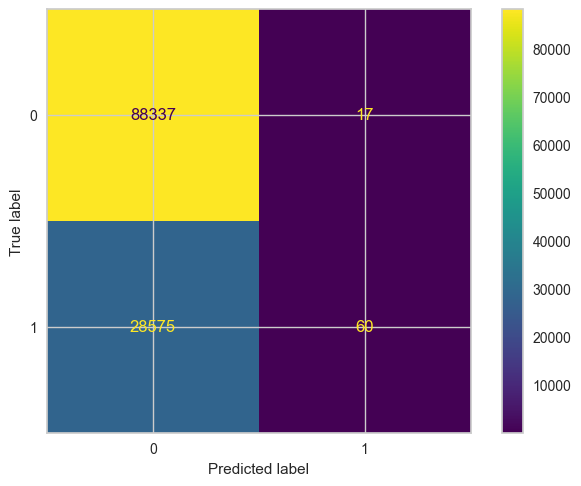

In [111]:
# matriz de confusão com dados de treino
disp = ConfusionMatrixDisplay.from_estimator(xgb_tunned, X, y, values_format='d')

## Evaluation

- Matriz de confusão com dados de teste
  - Para rodar os dados de teste precisa fazer uma pipeline com pre-processador (imputar e transformar os dados)
- Refazer a análise com os datasets de 50% e 15% de permissividade de nulo por coluna

In [96]:
X_test = df_test.drop(columns=['TARGET'])
y_test = df_test['TARGET']
